# Optimizers

Common practices whenever training a deep neural network include:
* Applying a good initialization scheme (e.g., Xavier Initialization, unsupervised pretraining);
* using a good activation function (ReLU instead of sigmoid);
* using batch normalization;
* reusing parts of a pretrained network.

In this notebook, we will be studying an additional way to speed up training: **optimization methods**.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

To test these optimizers, let us consider the following function and its respective gradient matrix.

$$
    f(x, y) = x^2 + 2xy + y^2
$$

$$
    \nabla f = \begin{bmatrix} 2x + 2y \\ 2y + 2x\end{bmatrix}
$$

In [6]:
def f(x, y): return 0.4 * x ** 2 + x * y + 1.3 * y ** 2
X, Y = np.mgrid[-4: 4:0.1, -4: 4:0.1]

In [7]:
def gradf(f , *xv, epsilon=1e-6):
    """
    Approximate the numerical gradient of f
    at around xv
    
    Parameters
    ----------
    f: function
        vectorized and derivable function
    xv: the evaluating points
    
    Returns
    -------
    np.array of shape (len(xv),);
    """
    nx = len(xv)
    xv_stack = np.array([xv for _ in range(nx)]).reshape(-1, nx)
    xv_stack_pos = (xv_stack + np.eye(nx) * epsilon).T
    xv_stack_neg = (xv_stack - np.eye(nx) * epsilon).T
    grad = (f(*xv_stack_pos) - f(*xv_stack_neg)) / (2 * epsilon)
    return grad

### *Plain Vanilla* Gradient-Descent
The update rule for the gradient descent is given by:
$$
    x:= x - \alpha\nabla f(x)
$$

With
* $\alpha$, the learning rate

Total steps taken: 685


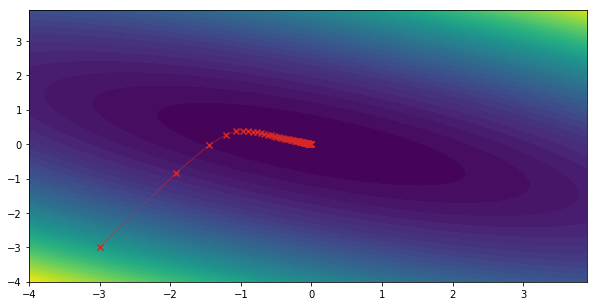

In [66]:
x0 = np.array([-3, -3])
alpha = 0.2
learning_history = [x0]
f1, f0 = f(*x0), 1e6
while abs(f1 / f0 - 1) > 1e-2:
    x0 = x0 - alpha * gradf(f, *x0)
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)

plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")

### Momentum Optimization
The update rule for the momentum optimization is given by:

$$
    \begin{align}
    m &:= \beta m + \alpha \nabla f(x)\\
    x &:= x - m
    \end{align}
$$

With,
* $\alpha$: learning rate
* $\beta$: momentum

The *momentum* coefficient, $\beta \in [0, 1)$, is used as an acceleration hyperparameter. The higher $\beta$ is, the less friction is. To see comprehend this, consider $\nabla f(x)$ fixed and let $m_{k}$ be the momentum term at the $k$-th iteration. Since

$$
    \begin{align}
    m_n &= \beta m_{n-1} + \alpha \nabla f(x)\\
        &= \beta \left(\beta m_{n-2} + \alpha \nabla f(x) \right) + \alpha \nabla f(x) \\
        &= \beta^2 m_{n-2} + \beta \alpha \nabla f(x) + \alpha \nabla f(x)\\
        &= \beta^3 m_{n-3} + \beta^2 \alpha \nabla f(x) + \beta \alpha \nabla f(x) + \alpha \nabla f(x)\\
        &= \ldots
    \end{align}
$$

In general,
$$
    m_n = \beta^{n} m_0 + \alpha \nabla f(x) \sum_{k=0}^{n-1} \beta^k
$$

Considering $m_0 = 1$ and taking $n\to\infty$, i.e., the *terminal* velocity, we see that
$$
    \begin{align}
    \lim_{n\to\infty} m_n &= \lim_{n\to\infty} \beta^{n} + \alpha \nabla f(x) \sum_{k=0}^{n-1} \beta^k \\
    &=\lim_{n\to\infty} \alpha \nabla f(x) \sum_{k=0}^{n-1} \beta^k\\
    \end{align}
$$

Recalling that $\sum_{k=0}^{n-1}\beta^k = \frac{1 - \beta^n}{1 - \beta}$, we conclude that

$$
    \lim_{n\to\infty} m_n = \frac{\alpha \nabla f}{1 - \beta}
$$

E.g., for $\beta =0.99$, this would imply going 100x faster than gradient descent!

Total steps taken: 97


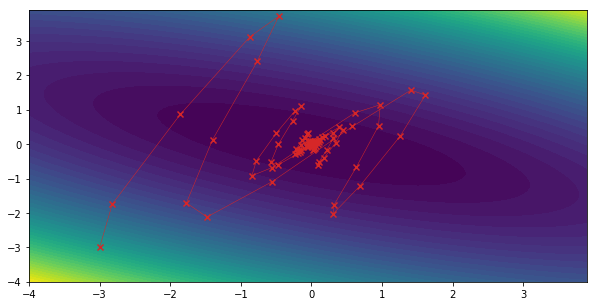

In [85]:
x0 = np.array([-3, -3])
learning_history = [x0]
f1, f0 = f(*x0), 1e6

alpha, beta = 0.2, 0.9
m = 1
f1, f0 = f(*x0), 1e6
while abs(f1 / f0 - 1) > 1e-2:
    m = beta * m + alpha * gradf(f, *x0)
    x0 = x0 - m
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)
plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")

### Nesterov Accelerated Gradient

NAG modifies the momentum optimizer by evaluating the gradient of the function slightly ahead towards the direction of the momentum

$$
    m := \beta m + \alpha \nabla f(x + \beta m)\\
    x := x - m
$$

Total steps taken: 87


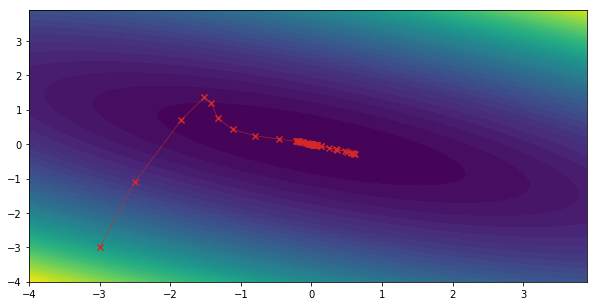

In [83]:
x0 = np.array([-3, -3])
learning_history = [x0]
f1, f0 = f(*x0), 1e6

alpha, beta = 0.2, 0.9
m = 1
f1, f0 = f(*x0), 1e6
while abs(f1 / f0 - 1) > 1e-2:
    m = beta * m + alpha * gradf(f, *(x0 - beta * m))
    x0 = x0 - m
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)
plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")

### AdaGrad

The Adaptive Subgradient method (AdaGrad) attempts to fix the problem with elongated bowls in gradient descent in which the direction of steepest descent is not necesarily pointing towards the minimun by scaling down the gradient vector along the steepest dimensions.

$$
    s := s + \nabla f(x) \odot \nabla f(x)\\
    x := x - \alpha \nabla f(x) \oslash \sqrt{s + \epsilon}
$$

AdaGrad often performs well for simple quadratic problems, but unfortunately **it often stops too early when training neural networks**.

Total steps taken: 619


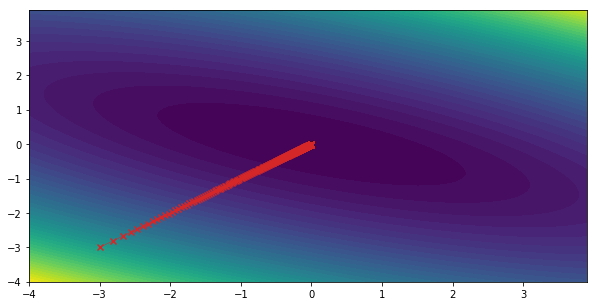

In [69]:
x0 = np.array([-3, -3])
learning_history = [x0]
f1, f0 = f(*x0), 1e6

alpha = 0.2
epsilon = 1e-10
s = 1
f1, f0 = f(*x0), 1e6
while abs(f1 / f0 - 1) > 1e-2:
    gradfx = gradf(f, *(x0))
    s = s + gradfx ** 2
    x0 = x0 - alpha * gradfx / np.sqrt(s + epsilon)
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)
plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")

### RMSProp

Whereas AdaGrad considers the history of the gradients, RMSProp considers only a subset of the gradients by *exponentially decaying* the past values.

$$
    s := \beta s + (1 - \beta) \nabla f(x) \odot \nabla f(x)\\
    x := x - \alpha \nabla f(x) \oslash \sqrt{s + \epsilon}
$$

Total steps taken: 160


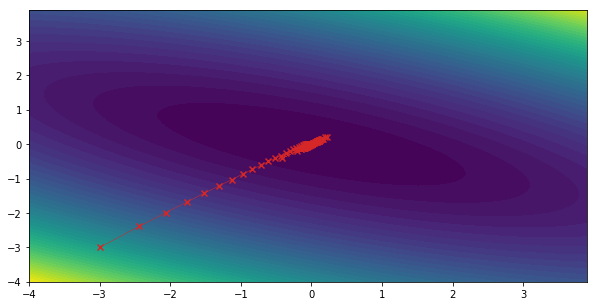

In [71]:
x0 = np.array([-3, -3])
learning_history = [x0]
f1, f0 = f(*x0), 1e6

alpha, beta = 0.2, 0.9
epsilon = 1e-10
s = 0.9
f1, f0 = f(*x0), 1e6
while abs(f1 / f0 - 1) > 1e-2:
    gradfx = gradf(f, *(x0))
    s = beta * s + (1 - beta) * gradfx ** 2
    x0 = x0 - alpha * gradfx / np.sqrt(s + epsilon)
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)
plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")

### ADAM Optimization

Adaptive moment estimation, or ADAM, combines the ideas of momentum optimization and RMSProp: keeping track of both exponentially decaying average of past gradients and exponentially decaying average of past squared gradients.

Update
$$
    m := \beta_1 m + (1 - \beta_1) \nabla f(x)\\
    s := \beta_2 s + (1 - \beta_2) \nabla f(x) \odot \nabla f(x)\\
$$

Compute
$$
    \hat m := \frac{m}{1 - \beta_1^t} \\
    \hat s := \frac{s}{1 - \beta_2^t}
$$

Take the learning step:
$$
    x := x - \alpha \hat m \oslash \sqrt{\hat s + \epsilon}
$$

Total steps taken: 268


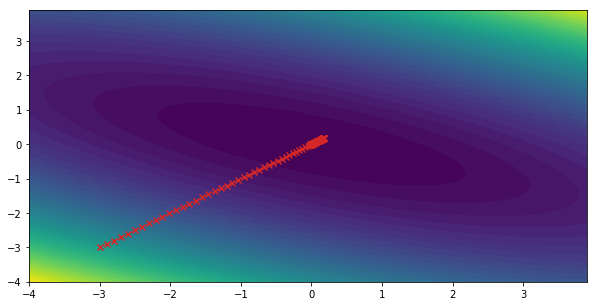

In [99]:
x0 = np.array([-3, -3])
learning_history = [x0]
f1, f0 = f(*x0), 1e6

n_params = len(x0)
alpha = 0.1
beta1, beta2 = 0.9, 0.999
epsilon = 1e-8
s, m = np.zeros(n_params), np.zeros(n_params)

f1, f0 = f(*x0), 1e6
t = 1
while abs(f1 / f0 - 1) > 1e-3:
    gradfx = gradf(f, *(x0))
    # Step 1
    m = beta1 * m + (1 - beta1) * gradfx
    s = beta2 * s + (1 - beta2) * gradfx ** 2
    # Step 2
    hat_m = m / (1 - beta1 ** t)
    hat_s = s / (1 - beta2 ** t)
    #Step 3
    x0 = x0 - alpha * hat_m / np.sqrt(hat_s + epsilon)
    
    t += 1
    learning_history.append(x0)
    f0, f1 = f1, f(*x0)
plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(*np.r_[learning_history].T, color="tab:red", marker="x")
plt.plot(*np.r_[learning_history].T, color="tab:red", linewidth=0.5)
print(f"Total steps taken: {len(learning_history):,}")